In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Initialize an empty list to hold DataFrames
frames = []

NV_error = []
FV_error = []
EV_error = []
DV_error = []

NV_var = []
FV_var = []
EV_var = []
DV_var = []

participant = []

trials_removed = []

# Assuming file names are in the format 'participant1.csv', 'participant2.csv', etc.
# Adjust the range as per the number of participants
for i in range(3, 16):  # Change 9 to a higher number if you have more participants
    file_name = f'../data/summary_data/p{i}_Testing.csv'  # Constructs the file name
    df = pd.read_csv(file_name)  # Reads the file into a DataFrame
    df['participant'] = i  # Adds the participant number
    df = df.drop('block', axis=1)  # Drops the column you don't need
    df['error'] = df['end_angles'] - df['target_angle']
    
    participant.append(i)
    len1 = len(df)
    df = df[(df["move_times"] > 0.2) & (df['move_times'] < 0.7) & (df['error'] < 40) & (df['error'] > -40)]
    trials_removed.append(len1 - len(df))
    frames.append(df)  # Appends the DataFrame to the list
    NV_error.append(df[(df["terminal_feedback"] == 0) & (df['vibration'] == 0)]['error'].mean())
    FV_error.append(df[(df["terminal_feedback"] == 0) & (df['vibration'] == 3)]['error'].mean())
    EV_error.append(df[(df["terminal_feedback"] == 0) & (df['vibration'] == 2)]['error'].mean())
    DV_error.append(df[(df["terminal_feedback"] == 0) & (df['vibration'] == 1)]['error'].mean())

    NV_var.append(np.std(df[(df["terminal_feedback"] == 0) & (df['vibration'] == 0)]['end_angles']))
    FV_var.append(np.std(df[(df["terminal_feedback"] == 0) & (df['vibration'] == 3)]['end_angles']))
    EV_var.append(np.std(df[(df["terminal_feedback"] == 0) & (df['vibration'] == 2)]['end_angles']))
    DV_var.append(np.std(df[(df["terminal_feedback"] == 0) & (df['vibration'] == 1)]['end_angles']))

# Concatenate all data frames
combined_df = pd.concat(frames, ignore_index=True)

data_error = pd.DataFrame({'participant': participant, 'NV': NV_error, 'FV': FV_error, 'EV': EV_error, 'DV': DV_error})
data_error.to_csv('../results/error_data.csv', index=False)

var_df = pd.DataFrame({'participant': participant, 'NV': NV_var, 'FV': FV_var, 'EV': EV_var, 'DV': DV_var})
var_df.to_csv('../results/var_data.csv', index=False)

NV_error = np.array(NV_error)
FV_error = np.array(FV_error)
EV_error = np.array(EV_error)
DV_error = np.array(DV_error)

FV_error = FV_error - NV_error
EV_error = EV_error - NV_error
DV_error = DV_error - NV_error

error_df = pd.DataFrame({'participant': participant, 'FV': FV_error, 'EV': EV_error, 'DV': DV_error})
long_df = pd.melt(error_df, id_vars=['participant'], 
                  var_name='vibration', value_name='error')

# var_df = pd.DataFrame({'participant': participant, 'BV': BV_var, 'TV': TV_var, 'DV': DV_var})
var_long_df = pd.melt(var_df, id_vars=['participant'], 
                  var_name='vibration', value_name='variation')
print(trials_removed)

[10, 3, 17, 9, 9, 22, 19, 67, 39, 32, 7, 35, 9]


In [4]:
combined_df.head()

,Unnamed: 0,trial_num,move_times,wrist_x_end,wrist_y_end,curs_x_end,curs_y_end,end_angles,target_angle,rt,...,terminal_feedback,rotation_direction,rotation,rotation_angle,clamp,clamp_angle,vibration,trial_type,participant,error
0,0.0,1.0,0.389625,4.600920,5.258485,4.600920,5.258485,48.815642,48.0,0.397910,...,1,1,0,0,0,0,0,0,3,0.815642
1,1.0,2.0,0.498364,0.533966,6.976994,0.533966,6.976994,85.623549,90.0,0.200331,...,1,1,0,0,0,0,0,0,3,-4.376451
2,2.0,3.0,0.501607,-4.483418,5.352423,-4.483418,5.352423,129.950980,138.0,0.221950,...,1,1,0,0,0,0,0,0,3,-8.049020
3,4.0,5.0,0.483748,-0.278320,6.999097,-0.278320,6.999097,92.277173,90.0,0.305813,...,1,1,0,0,0,0,0,0,3,2.277173
4,5.0,6.0,0.375694,-4.582882,5.280588,-4.582882,5.280588,130.953842,137.0,0.332880,...,1,1,0,0,0,0,0,0,3,-6.046158


C:\Users\gesch\AppData\Local\Temp\ipykernel_27820\2261067203.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_errors = combined_df.groupby(['participant', 'target_pos', 'vibration']).error.mean().reset_index()


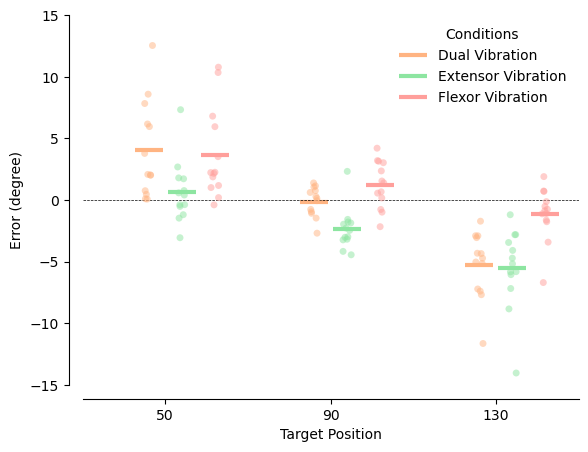

In [66]:
combined_df['vibration'] = pd.Categorical(combined_df['vibration'])
mean_errors = combined_df.groupby(['participant', 'target_pos', 'vibration']).error.mean().reset_index()
control_errors = mean_errors[mean_errors['vibration'] == 0]
control_errors = control_errors.rename(columns={'error': 'control_error'})
mean_errors = pd.merge(mean_errors, control_errors[['participant', 'target_pos', 'control_error']], on=['participant', 'target_pos'])
mean_errors['error_diff'] = mean_errors['error'] - mean_errors['control_error']
experimental_diffs = mean_errors[mean_errors['vibration'] != 0]
experimental_diffs = experimental_diffs[experimental_diffs['vibration'] != 0]


fig, ax = plt.subplots()
sns.stripplot(x='target_pos', y='error_diff', data=experimental_diffs, ax=ax, alpha=0.5,
              hue="vibration",dodge=True, legend=False, palette='pastel')
sns.pointplot(x='target_pos', y='error_diff', data=experimental_diffs, ax=ax, hue="vibration", dodge=0.6, linestyle='none',
              errorbar=None, marker='_', markersize=20, markeredgewidth=3, palette='pastel')
ax.set_xlabel('Constant error')
ax.set_xlabel('Target Position')
ax.set_ylabel("Error (degree)")
ax.set_ylim([-15, 15])
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
sns.despine(offset=10)
handles, labels = ax.get_legend_handles_labels()
desired_handles = handles[1:4] 
desired_labels = ['Dual Vibration', 'Extensor Vibration', 'Flexor Vibration']
# desired_labels = labels[1:4]  # Keep only the first three labels
ax.legend(desired_handles, desired_labels, title='Conditions', frameon=False)
plt.show()
fig.savefig('../results/const_error_plot.png', dpi=1200)


C:\Users\gesch\AppData\Local\Temp\ipykernel_27820\1487787898.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_errors = combined_df.groupby(['participant', 'target_pos', 'vibration']).error.std().reset_index()


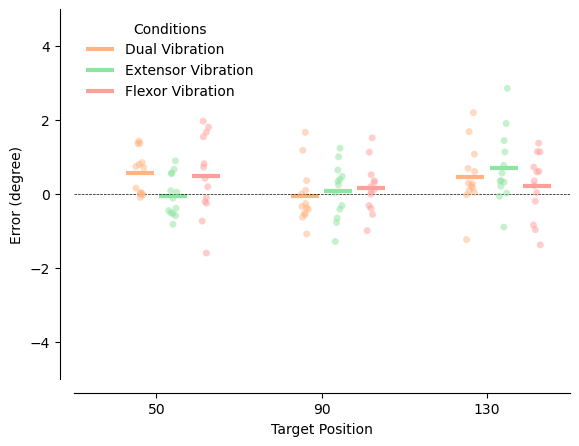

In [65]:
combined_df['vibration'] = pd.Categorical(combined_df['vibration'])
mean_errors = combined_df.groupby(['participant', 'target_pos', 'vibration']).error.std().reset_index()
control_errors = mean_errors[mean_errors['vibration'] == 0]
control_errors = control_errors.rename(columns={'error': 'control_error'})
mean_errors = pd.merge(mean_errors, control_errors[['participant', 'target_pos', 'control_error']], on=['participant', 'target_pos'])
mean_errors['error_diff'] = mean_errors['error'] - mean_errors['control_error']
experimental_diffs = mean_errors[mean_errors['vibration'] != 0]
experimental_diffs = experimental_diffs[experimental_diffs['vibration'] != 0]


fig, ax = plt.subplots()
sns.stripplot(x='target_pos', y='error_diff', data=experimental_diffs, ax=ax, alpha=0.5,
              hue="vibration",dodge=True, legend=False, palette='pastel')
sns.pointplot(x='target_pos', y='error_diff', data=experimental_diffs, ax=ax, hue="vibration", dodge=0.6, linestyle='none',
              errorbar=None, marker='_', markersize=20, markeredgewidth=3, palette='pastel')
ax.set_xlabel('Constant error')
ax.set_xlabel('Target Position')
ax.set_ylabel("Error (degree)")
ax.set_ylim([-5, 5])
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
sns.despine(offset=10)
handles, labels = ax.get_legend_handles_labels()
desired_handles = handles[1:4] 
desired_labels = ['Dual Vibration', 'Extensor Vibration', 'Flexor Vibration']
# desired_labels = labels[1:4]  # Keep only the first three labels
ax.legend(desired_handles, desired_labels, title='Conditions', frameon=False)
plt.show()
fig.savefig('../results/var_error_plot.png', dpi=1200)